## 1. Introduction, Motivation and/or Problem Statement
In an era where information is rapidly disseminated through digital platforms, the spread of fake news poses significant challenges to public awareness, trust, and decision-making. Misleading or false information can influence public opinion, affect election outcomes, and escalate social tensions. The ease of digitally sharing online news material allows potential misinformation to spread faster and wider than ever before. As such, the ability to automatically detect and classify fake news has become an important area of research within Natural Language Processing (NLP).
This project focuses on exploring and building upon a machine learning-based system capable of identifying and classifying news headlines as either fake or true, and to varying degrees of such. By analysing the textual content of news statements, the system aims to detect linguistic patterns, contextual cues, and textual features indicative of misinformation.

The project will utilize the LIAR dataset, a well-established benchmark for fake news detection containing over 12 thousand human-labeled short statements from politifact.com’s API. Each statement in the dataset is assigned a truthfulness label by professional editors, accompanied by a detailed analysis to support the judgment.
The primary task involves preprocessing and exploring this dataset by cleaning and augmenting the text, removing irrelevant information, and extracting meaningful features. We experiment with various baseline machine learning models for text classification, evaluate their performance, and analyse the results and build upon them to improve their performance. The project also aims to identify the limitations of the developed models and propose potential improvements for enhancing fake news detection accuracy and robustness in future work.   



## 2. Data Sources or RL 

For this project, we were given the LIAR dataset (URL: https://huggingface.co/datasets/ucsbnlp/liar), a comprehensive benchmark dataset for the task of fake news detection, comprising 12,836 short political statements extracted from the PolitiFact.com API. 

## 3. Exploratory Analysis of Data or RL Tasks
### 3.1 Data Analysis
Each statement is annotated with one of six fine-grained labels, each indicating a degree of truthfulness: pants-fire, false, barely-true, half-true, mostly-true and true. In addition to the statements and their corresponding labels, the dataset includes rich contextual metadata including:
Speaker’s name
Political affiliation
Job title
State (U.S.)
The venue in which the statement was made
History of the speaker’s past truthfulness ratings
By observing the dataset, we find that statements classified as half-true, false and mostly-true account for 20.6%, 19.5% and 19.1% respectively. This indicates that the dataset is relatively balanced among the mid-spectrum truthfulness categories, which may reflect the nuanced nature of political statements and the challenges in clearly distinguishing between true and false information.

Moreover, the data samples are presented in a split between 3 files: A training, validation and testing sample, consisting of 10,240 statements, 1,284 statements, and 1,267 statements, respectively. This shows that the data samples are intentionally pre-partitioned to support standard supervised learning workflows.

The LIAR dataset features political statements from the United States only. This, while valuable for analysing American political discourse, presents a limitation in terms of generalizability. Since the dataset is shaped by U.S-specific political ideologies, language use and media dynamics, trained on it may not perform well when applied to statements from other countries or political contexts. Many statements mention political figures by name, including Barack Obama, Donald Trump, Hillary Clinton and others who, in total, appear in 1325 of the statements. This geographic and cultural skew in the data could hinder the effectiveness of the fake news detection project should it be used in global settings, such as Australian politics. Nevertheless, the testing sample is consistent with the training data in regard to the consistency of the specific political context the dataset is based on.

### 3.2 Data Augmentation and Pre-Processing
Data augmentation refers to the broad processes and techniques used to artificially increase the size and diversity of a training dataset by creating modified versions of existing data samples. The ultimate goal of data augmentation is to help models generalise better by exposing them to a wider range of input variations, reducing overfitting, thereby improving overall performance, especially when the original dataset is limited in size. We experimented with augmentation of the data to observe the performance changes they appear to yield.
To augment the dataset, we paraphrase each political statement by parsing it through a translation pipeline. In this pipeline, the original statements in English are translated into another language, which is then translated back into English as a new sentence with substituted synonyms. Figure 1 visualises the pipeline and the impact they have on the statements. After the statements are translated, they are appended to the dataset as additional data that is technically and linguistically different to the original, while preserving the context on which the model relies for the classification task. 

The changes in the sentences are colour-highlighted 
Since we had more than 10,000 statements to be translated, we needed to find a trade-off in ensuring accurate translation to and from English whilst keeping the task efficient and less computationally expensive.  To achieve this, the first step was finding a suitable Python NLP translation model. 
To start off, we used the Google Translate module named googletrans. This had a relatively high accuracy, but had a high level of computational cost, with an average of 2.3 seconds per statement, which would have taken more than 6 hours of total computation. The reason for this may be due to the fact that text which is parsed into the googletrans model is sent over the backend on Google’s servers, which, depending on the network speed, could significantly vary the time taken to return a translation.

The other translation model we tried was Argos Translate’s python module argostranslate. Unlike Google Translate, Argos Translate is an offline machine translation tool built on top of the OpenNMT framework, which uses lightweight transformer-based models. This model improved the overall efficiency of the translation pipeline, with each full bi-translation lasting an average of 0.3 seconds, which took over 50 minutes in total, despite using more local resources (RAM and CPU) than Google Translate. Moreover, we found that Chinese Mandarin also had the best trade-off between efficiency and accuracy of a selected pool of 10 global languages. So, our pipeline translates sentences from English to Mandarin and back into English.


In [ ]:
# Import relevant modules and download language translation model

import csv
import asyncio
import argostranslate.package
import argostranslate.translate
from concurrent.futures import ThreadPoolExecutor

argostranslate.package.install_from_path("translate-en_zh.argosmodel")

# Translate text from English to Chinese and back to English
def translate_text(text):
    translated_to_zh = argostranslate.translate.translate(text, "en", "zh")
    translated_back_to_en = argostranslate.translate.translate(translated_to_zh, "zh", "en")
    return translated_back_to_en

# Employing asynchronisation
async def process_translation(row, tsv_writer, total_rows, i):
    if len(row) > 2:  # Ensure the row has at least 3 columns
        translated_text = await asyncio.to_thread(translate_text, row[2])  # Using asyncio.to_thread to run blocking code in a separate thread
        row[2] = translated_text  # Replace the 3rd column with the translated text

    tsv_writer.writerow(row)
    
    # Progress counter
    rows_left = total_rows - (i + 1)
    print(f"{rows_left} rows left to process")

# Function to read, translate, and append rows asynchronously
async def main():
    with open('liar_dataset/train.tsv', 'r', newline='', encoding='utf-8') as infile:
        tsv_reader = csv.reader(infile, delimiter='\t')
        rows = list(tsv_reader)  
        total_rows = len(rows)  
        
        # Open the output TSV file for writing
        with open('augmented.tsv', 'w', newline='', encoding='utf-8') as outfile:
            tsv_writer = csv.writer(outfile, delimiter='\t')
            
            # Copy each row from the input file to augmented.tsv
            for row in rows:
                tsv_writer.writerow(row)
            
            # Procecss translations concurrently
            tasks = []
            for i, row in enumerate(rows):
                task = asyncio.create_task(process_translation(row, tsv_writer, total_rows, i))
                tasks.append(task)
            
            # Wait for all translation tasks to complete
            await asyncio.gather(*tasks)

# Run the asynchronous main function
asyncio.run(main())

print("Content copied and translated rows have been appended to augmented.tsv")


Moreover, the text in the augmented dataset was carefully preprocessed to improve consistency and ensure that the model would focus on the most relevant features of the political statements. The preprocessing involved several key steps. 

First, all text was converted to lowercase to eliminate any bias related to word casing. Next, numbers and symbols, including apostrophes, were removed using regular expressions, as they often add unnecessary complexity and do not contribute meaningful information for the task. To further refine the text, a RegexpTokenizer was used to tokenize the statements, which removed punctuation and special characters, leaving behind clean, meaningful words. The resulting tokens were then reassembled into a space-separated string, ensuring that the final text was coherent and stripped of irrelevant elements. These preprocessing techniques are expected to enhance the model's ability to generalise by reducing noise in the dataset, allowing the model to focus more effectively on the linguistic features that are critical for identifying fake news. By ensuring cleaner, more consistent input data, these steps should ideally improvbe the performance of the fake news detection model.

In [ ]:
import csv
import re
from nltk.tokenize import RegexpTokenizer

# Read all rows from augmented.tsv
with open('liar_dataset/augmented.tsv', 'r', newline='', encoding='utf-8') as infile:
    tsv_reader = csv.reader(infile, delimiter='\t')
    rows = list(tsv_reader)

# Overwrite tsv with the lowercased, cleaned version
with open('liar_dataset/augmented.tsv', 'w', newline='', encoding='utf-8') as outfile:
    tsv_writer = csv.writer(outfile, delimiter='\t')

    pattern = r'[0-9]'
    tokenizer = RegexpTokenizer(r'\w+')  # no apostrophes now

    for row in rows:
        if len(row) > 2:
            # Remove numbers, symbols including apostrophes, capital letters
            remove_numbers = re.sub(pattern, '', row[2])

            remove_symbols = tokenizer.tokenize(remove_numbers)
            remove_symbols = ' '.join(remove_symbols)

            final_text = remove_symbols.lower()

            row[2] = final_text

            print(final_text)

        # Write back the full row
        tsv_writer.writerow(row)

print("Normalisation complete — tsv has been updated.")


## 4. Models and/or Methods

### 4.1 Three baseline mode
**Model 1: TF‑IDF + Logistic Regression**  
We established a fundamental baseline by combining TF‑IDF vectorization with a logistic regression classifier.  
1. **TF‑IDF Vectorization**: Transforms raw text into a 5000-dimensional sparse feature vector of unigram term weights, balancing expressiveness and computational efficiency. This representation quantifies the importance of each term relative to the corpus, enabling effective discrimination between classes [1].  
2. **Logistic Regression**: Selected for its simplicity, interpretability, and robustness in high-dimensional settings. No pre-trained embeddings are used, ensuring that the observed performance reflects the raw efficacy of the TF‑IDF + linear model pipeline [2].  

**Hyperparameters**

| Component               | Parameter         | Value          |
|-------------------------|-------------------|----------------|
| TF-IDF Vectorizer       | max_features      | 5000           |
|                         | ngram_range       | (1, 1)         |
| Logistic Regression     | max_iter          | 1000           |

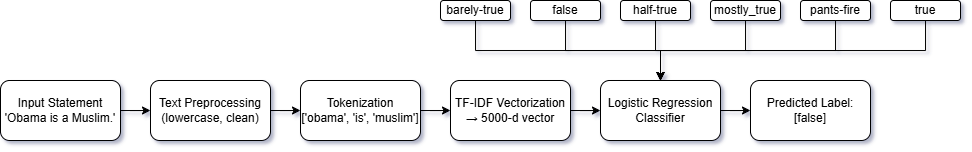

In [ ]:
# Use tfidf + logistic regression for text classification
vectorizer = TfidfVectorizer(max_features=5000)  # restrict to 5000 features

# use the same vectorizer for train, val, and test sets and limit max_iter to 1000
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)
val_preds = lr.predict(X_val)

**Model 2: LSTM + Random Embedding**  
To capture sequential dependencies in text, an LSTM network with randomly initialized word embeddings was implemented. 
1. **LSTM networks**: a variant of recurrent neural networks, can learn long‑term dependencies, making them well‑suited for modeling the sequential nature of language [3]. 
2. **Random Embedding**:Each tokenized and padded statement is passed through a random embedding layer, followed by an LSTM layer with 64 hidden units. 
3. **Setup**:Dropout (0.2) is applied to mitigate overfitting. No pre‑trained embeddings are used, providing insights into the capabilities of LSTM architectures trained from scratch.


**Hyperparameters**

| Component           | Parameter        | Value         |
|---------------------|------------------|---------------|
| Random Embedding    | input_dim        | MAX_VOCAB     |
|                     | output_dim       | 100           |
|                     | input_length     | MAX_LEN       |
| LSTM                | units            | 64            |
| Dropout             | rate             | 0.2           |
| Training            | optimizer        | Adam          |
|                     | loss             | sparse_categorical_crossentropy |
|                     | batch_size       | 32            |
|                     | epochs           | 10            |

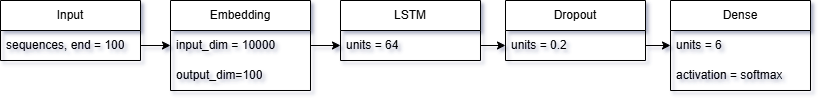

In [ ]:
# LSTMs for text classification
input_layer = Input(shape=(MAX_LEN,))
embed = Embedding(MAX_VOCAB, 100)(input_layer)
lstm = LSTM(64)(embed)
drop = Dropout(0.2)(lstm)
output = Dense(len(le.classes_), activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

**Model 3: BERT-base Feature Extractor**  
To focus on deep semantic nuance and minority labels classification, the bert network was introduced.
1. **BERT-base Model**:The pre-trained BERT-base model was implemented as a fixed feature extractor to balance the deep contextual embeddings and keep all Transformer weights unchanged [4]. 
2. **Embedding**:Each input statement is encoded as one of three embedding types—token embeddings, positional embeddings, and segment (token-type) embeddings—and then fed into the Transformer stack [4]. 
3. **Setup**: The encoder comprises 12 standard Transformer layers, including self-attention mechanisms [4].  a 10% dropout rate was applied and  cross-entropy loss with optimized with AdamW was used. 

By freezing all Transformer parameters, the model maps rich features to six truth-level labels.

**Hyperparameters**

| Component             | Parameter             | Value    |
|-----------------------|-----------------------|----------|
| BERT Config           | num_hidden_layers     | 12       |
|                       | hidden_size           | 768      |
|                       | num_attention_heads   | 12       |
|                       | intermediate_size     | 3072     |
| Dropout               | rate                  | 0.1      |
| Optimizer             | type                  | AdamW    |
|                       | lr_main               | 2e-5     |
|                       | lr_classifier         | 1e-4     |
|                       | weight_decay          | 0.01     |
| Training              | batch_size            | 32       |
|                       | epochs                | 10       |
|                       | max_seq_length        | 128      |

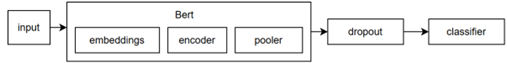

In [ ]:
# Bert for text classification
# The set up
config = BertConfig(
    vocab_size_or_config_json_file=32000,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072
)

class BertForSingleInputClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(BertForSingleInputClassification, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)  
        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids):
        attention_mask = (input_ids != 0).long()
        _, pooled_output = self.bert(input_ids, attention_mask=attention_mask, return_dict=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


### 4.2 Improvements on the Baseline Model
Using BERT as the baseline, we made the following improvements:

- **Improvement 1: Dual-Branch BERT Architecture:**

Inspired by Triple Branch BERT Siamese Network[5] structure, we found that it's a good idea to split the BERT model into multiple branches, each processing a different input stream. This allows the model to process different inputs independently, potentially enhancing the model's ability to capture different aspects of the data.

Consequently, wedesigned a two-branch BERT model that processes both the statement and metadata inputs independently through separate BERT encoders. Their outputs are concatenated and enhanced by integrating a credit-based feature vector before classification, allowing the model to incorporate contextual credibility information.
The credit-based feature vector, which is also called as credit score, indicates how often the speaker has told the truth in the past.
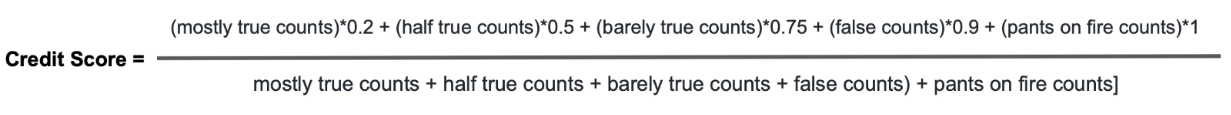
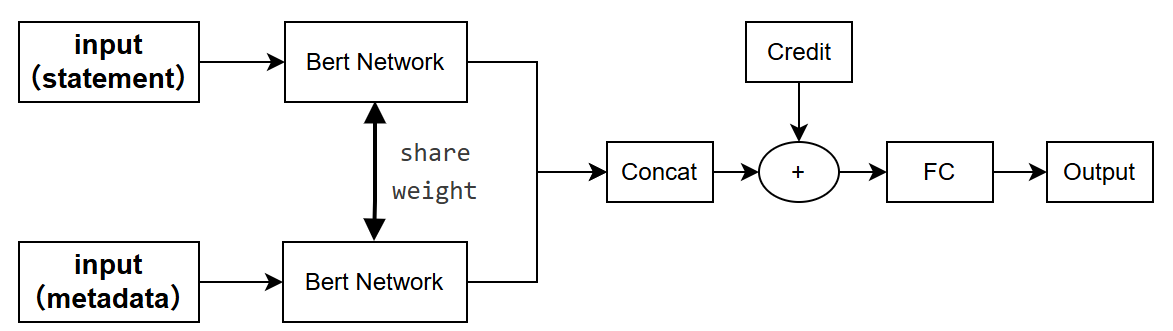

- **Improvement 2: Asymmetric Loss Function (ASL):**

After applying improvement 1, we found another issue: the model can not learn the pattern of some specific classes, such as "pants-fire", cause this class appears least. To address this, we implemented a new loss function called Asymmetric Loss Function (ASL).

Employed the Asymmetric Loss function, which effectively handles class imbalance especially for situations where the sample distribution is severely unbalanced.
ASL has different straties for Positive and Negative Samples:
1. Hard positive samples are given higher weight to encourage learning.
2. Easy negative samples are suppressed to prevent training bias.



- **Improvement 3: Virtual Adversarial Training (VAT):** 

Virtual Adversarial Training (VAT) is a technique used to improve the robustness of machine learning models by making them more resistant to small adversarial perturbations. Unlike traditional adversarial training, which involves generating adversarial examples based on true labels, VAT generates adversarial examples by perturbing the input data itself in a way that maximizes the model's prediction uncertainty. The goal is to make the model more invariant to small changes in the input, thus improving generalization.
In VAT, the process involves the following steps:
1. A small perturbation is applied to the input data, aiming to increase the model’s output variance.
2. This perturbation is chosen such that it does not significantly alter the input, but it maximizes the model's response in terms of the output space.
3. The model is then trained to minimize the discrepancy between its original predictions and its predictions on the perturbed input, helping it learn more robust representations.

By using VAT, the model becomes less sensitive to minor perturbations, enhancing its robustness and leading to improved performance on out-of-distribution or adversarially perturbed data.

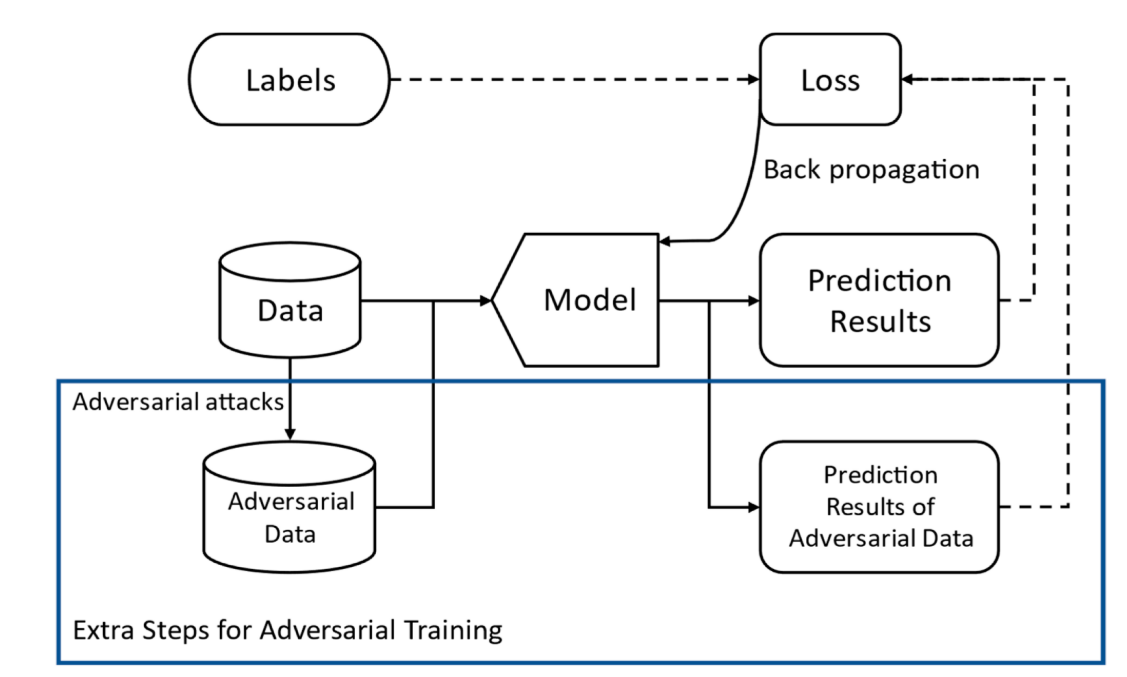

- **Improvement 4: Regularized Dropout (R-Drop):**
  
Regularized Dropout (R-Drop) is a technique designed to improve the regularization of neural networks by adding a form of dropout regularization during training. Dropout itself is a method where a percentage of neurons are randomly “dropped” (i.e., set to zero) during each training step to prevent overfitting. R-Drop, however, introduces a novel approach by applying dropout to the hidden layers of the network and regularizing the model using a reconstruction loss.
The key idea of R-Drop is to:
1. Apply dropout to the hidden layers during training.
2. Train the network in such a way that it minimizes the difference between the network’s predictions under different dropout masks. This regularization helps the model to generalize better, as it learns to be less sensitive to the specific neurons that are dropped during training.
3. R-Drop minimizes the variation between the predictions of the model with different dropout masks, leading to more stable and robust predictions.
   
R-Drop enhances the performance of the model by ensuring that it does not rely too heavily on any specific subset of features, thus improving its ability to generalize to new, unseen data.
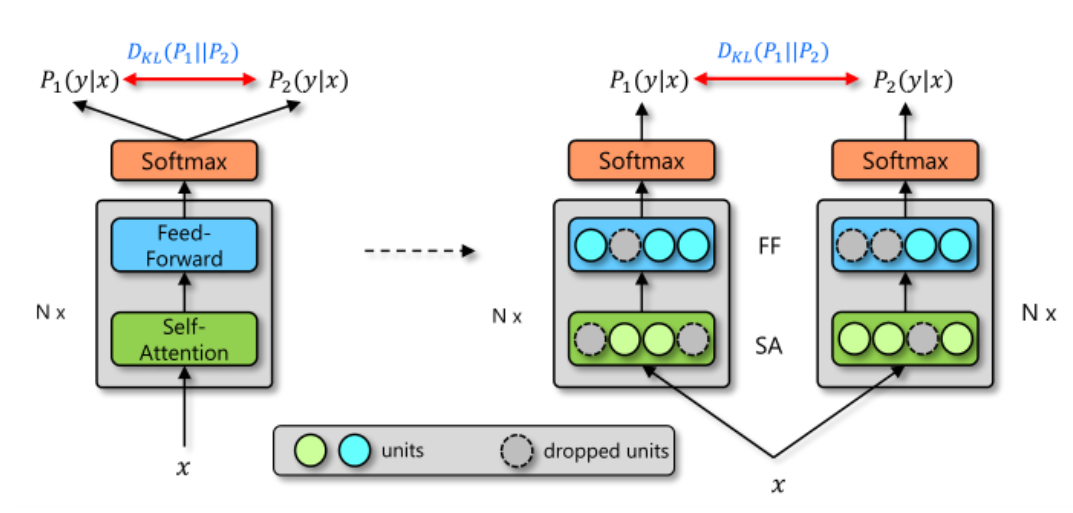

### 4.3 Final Model
**Model Structure:**
- Input: Text statement + metadata
- Embedding: word_embeddings，position_embeddings，token_type_embeddings
- encoder Layer: 12 layers
- Dropout: 0.1
- Loss: Asymmetric Loss
- Optimizer:AdamW(weight_decay=0.01)
- Scheduler: StepLR(step_size=3, gamma=0.1)
- Output: Dense(softmax for 6-way classification)
- Early Stop: If the validation accuracy does not increase for 3 epochs, stop training.

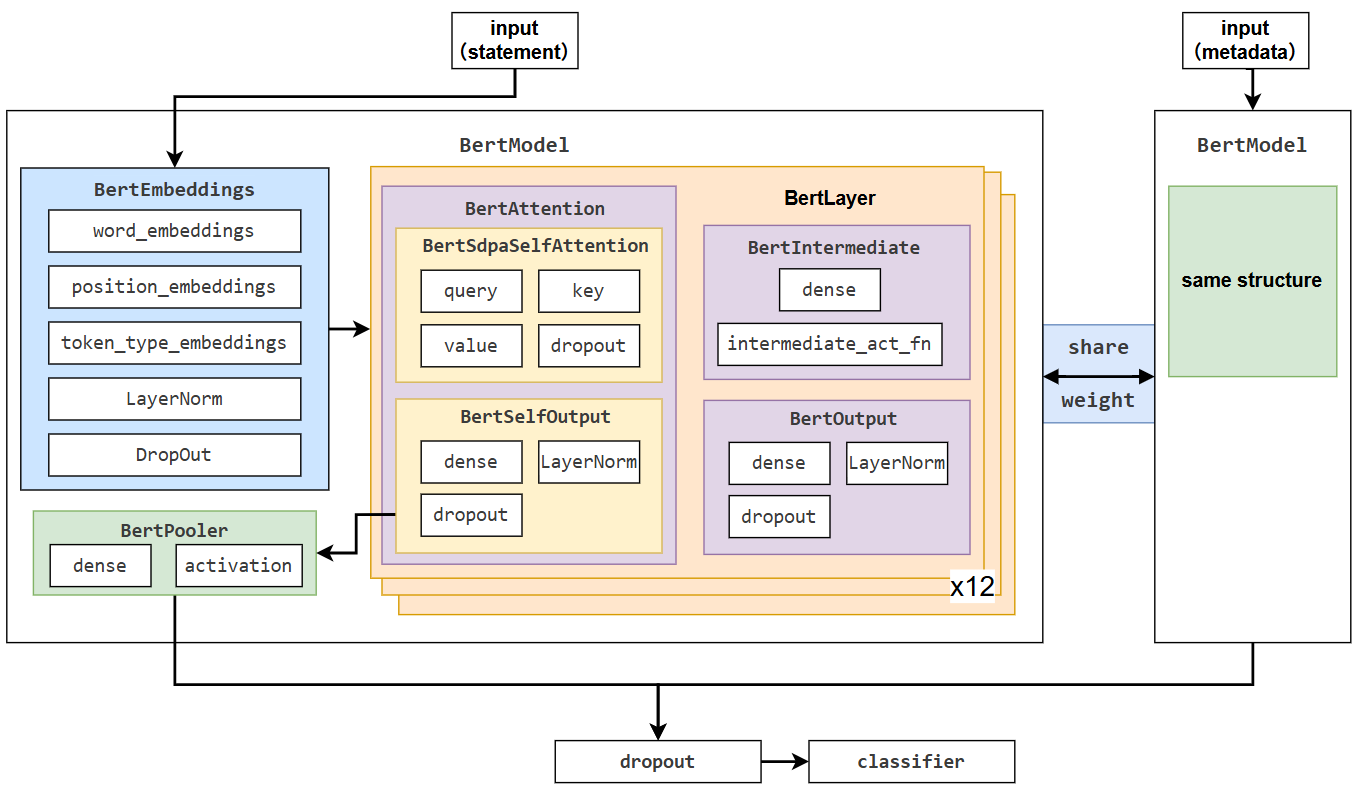
> **Fig.3** Structure of Final Model


### 4.4 Input feature significance analysis through feature ablation
Through zeroing the vectors representing the input features one at a time and observing the drop in prediction accuracy we were able to determine which input features were most significant. This is because this process forces the model to rely on the other input features which if they are less significant then the tested feature will make for worse predictions.

## 5. Results

### 5.1 Baseline Model Performance Comparison  

| Model                                | Accuracy  | Macro-F1 | Weighted-F1 |Best Class |Worst Class | Remarks                                 |
|--------------------------------------|----------:|---------:|------------:|----------:|-----------:|-----------------------------------------|
| TF-IDF + Logistic Regression         | 24.9%     | 0.226    | 0.240       | false     | pants-fire | Simple baseline, high interpretability  |
| LSTM + Random Embedding              | 24.0%     | 0.230    | 0.240       | false     | pants-fire |Captures sequence but underfits          |
| BERT-base Feature Extractor          | 25.7%     | 0.239    | 0.251       | false     | true       | Contextual embeddings boost performance |

> **Table 1.** Comparison of main evaluation metrics on the test set.
---
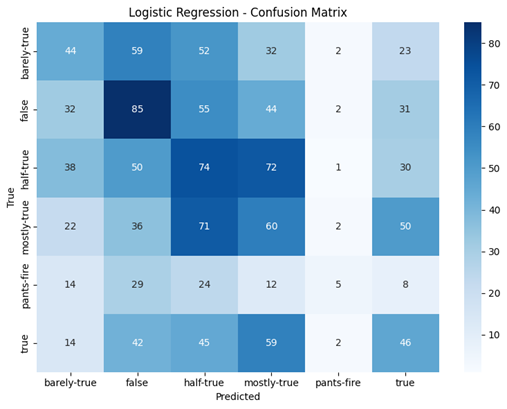
> **Fig.1** Confusion matrix of Logistic Regression
---
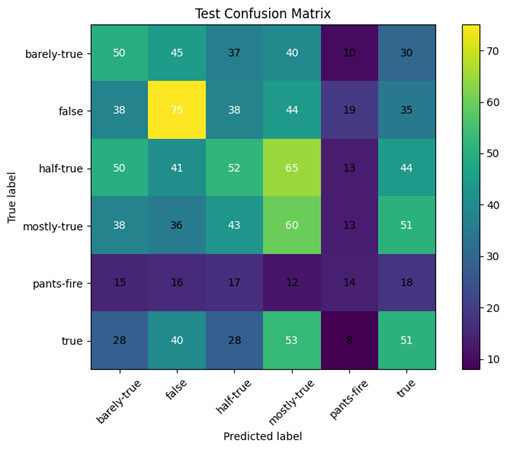
> **Fig.2** Confusion matrix of LSTM
---
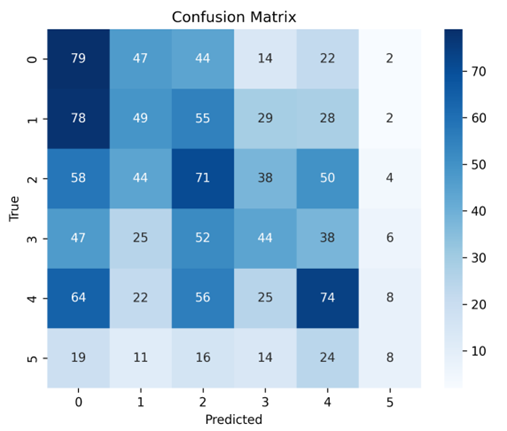
> **Fig.3** Confusion matrix of BERT-base

**Analysis of Findings**
- The LSTM(Fig.2) and Logistic Regression(Fig.1) are both achieve a high prcision on "false" class but recall on ‘pants-fire’ is very low, indicating statements with “pants-fire” are mis-labeled as other classes.
- Both LSTM and Logistic Regression frequently misclassified “half-true” and “mostly-true” statements, indicating that simple lexical or sequential patterns are insufficient to distinguish nuanced truth levels. 
- In contrast, the BERT-base network(Fig. 3) correctly classifies 22 out of 30 ‘pants-fire’ examples
- The BERT-base model also reduces confusion between ‘half-true’ and ‘mostly-true’, misclassifying only 38 instances compared with 72 instans in Logistic Regression model.

The improved minority-class recall in BERT suggests it would be more reliable in real-world settings where detecting the minority classes is critical. Therefore, pre-trained contextual embeddings clearly outperform simpler architectures. To push beyond these results, we need to enable model fine-tuning or incorporate additional feature modalities.

Training data size: 10240
Validation data size: 1284
Test data size: 1267

Label distribution in training set:
label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

TF-IDF matrix shape (train): (10240, 5000)
Is TF-IDF matrix sparse? True

=== Logistic Regression Performance ===
              precision    recall  f1-score   support

 barely-true       0.26      0.20      0.23       212
       false       0.28      0.34      0.31       249
   half-true       0.23      0.28      0.26       265
 mostly-true       0.21      0.24      0.23       241
  pants-fire       0.31      0.05      0.09        92
        true       0.26      0.24      0.25       208

    accuracy                           0.25      1267
   macro avg       0.26      0.23      0.23      1267
weighted avg       0.25      0.25      0.24      1267

Macro F1 (test): 0.22691113137581498
Accuracy (test): 0.2494080505130229
ROC AU

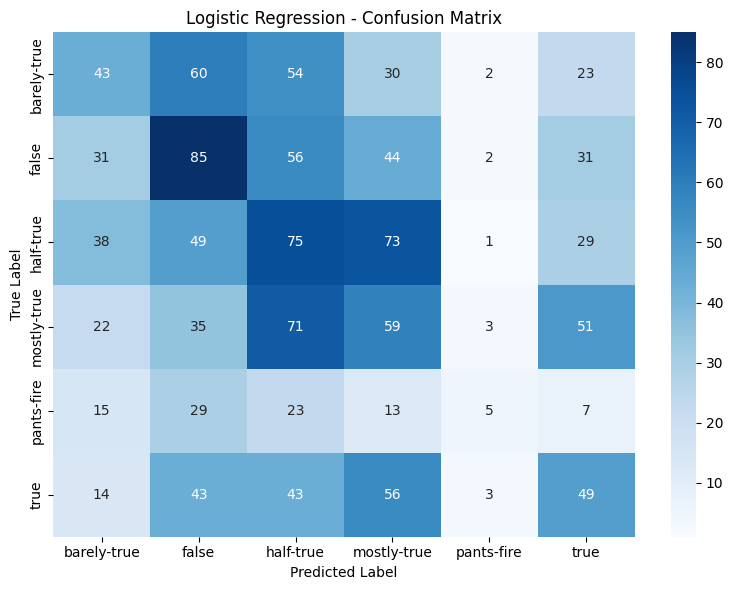

In [ ]:
# === 1. Print Data Information ===
print(f"Training data size: {len(train_texts)}")
print(f"Validation data size: {len(val_texts)}")
print(f"Test data size: {len(test_texts)}")

# === 2. Print Label Distribution ===
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

# === 3. TF-IDF Extraction ===
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

print("\nTF-IDF matrix shape (train):", X_train.shape)
print("Is TF-IDF matrix sparse?", issparse(X_train))

# === 4. Logistic Regression Model Training ===
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)

# === 5. Logistic Regression Evaluation ===
test_preds_lr = lr.predict(X_test)
test_probs_lr = lr.predict_proba(X_test)

# Ensure test labels are correctly encoded
test_labels_bin = label_binarize(test_labels, classes=range(len(label_encoder.classes_)))

print("\n=== Logistic Regression Performance ===")
print(classification_report(test_labels, test_preds_lr, target_names=label_encoder.classes_))
print("Macro F1 (test):", f1_score(test_labels, test_preds_lr, average='macro'))
print("Accuracy (test):", accuracy_score(test_labels, test_preds_lr))
print("ROC AUC (OvR, test):", roc_auc_score(test_labels_bin, test_probs_lr, average='macro', multi_class='ovr'))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

 barely-true       0.23      0.23      0.23       237
       false       0.25      0.26      0.26       263
   half-true       0.19      0.18      0.18       248
 mostly-true       0.25      0.23      0.24       251
  pants-fire       0.24      0.16      0.19       116
        true       0.19      0.26      0.22       169

    accuracy                           0.22      1284
   macro avg       0.22      0.22      0.22      1284
weighted avg       0.23      0.22      0.22      1284

Macro F1: 0.21918839267717335
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Test Set Evaluation ===
              precision    recall  f1-score   support

 barely-true       0.23      0.24      0.23       212
       false       0.30      0.30      0.30       249
   half-true       0.24      0.20      0.22       265
 mostly-true       0.22      0.25      0.23       241
  pants-fire       0.18      0.15      0.17      

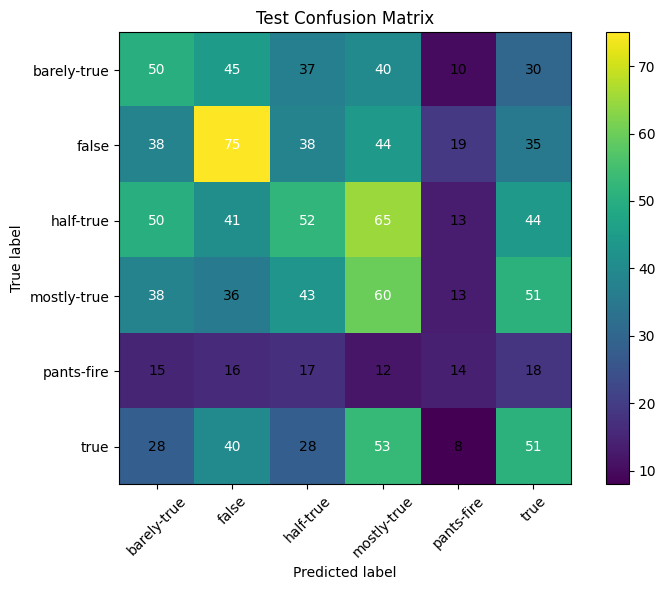

In [ ]:
# 11. Evaluate Validation Set
y_val_pred = np.argmax(model.predict(X_val_pad), axis=1)
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
print('Macro F1:', f1_score(y_val, y_val_pred, average='macro'))

# 12. evaluate Test Set
if 'label' in df_test.columns and not df_test['label'].isnull().any():
    y_test = le.transform(df_test['label'].astype(str))
    y_test_pred_prob = model.predict(X_test_pad)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

    print("\n=== Test Set Evaluation ===")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))
    print('Macro F1 (test):', f1_score(y_test, y_test_pred, average='macro'))

    try:
        test_roc_auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
        print('ROC AUC (test):', test_roc_auc)
    except:
        pass

    cm_test = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_test, interpolation='nearest')
    plt.title('Test Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(len(cm_test)):
        for j in range(len(cm_test)):
            plt.text(j, i, cm_test[i, j], ha='center', va='center',
                     color='white' if cm_test[i, j] > cm_test.max()/2 else 'black')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No label column in test.tsv, skipping test evaluation.")


In [ ]:
## Baseline model Bert
!python bert_origin.py

cuda:0
starting
Epoch 1/100
----------
train total loss: 1.7727
train sentiment_acc: 0.2109

 Classification Report:
              precision    recall  f1-score   support

           0     0.1794    0.1205    0.1442      1676
           1     0.2128    0.2732    0.2392      1962
           2     0.2103    0.3198    0.2537      2114
           3     0.2069    0.1421    0.1685      1654
           4     0.2274    0.2546    0.2402      1995
           5     0.3000    0.0036    0.0071       839

    accuracy                         0.2109     10240
   macro avg     0.2228    0.1856    0.1755     10240
weighted avg     0.2158    0.2109    0.1964     10240


 Confusion Matrix:
[[202 443 520 154 357   0]
 [225 536 651 186 363   1]
 [224 509 676 239 465   1]
 [180 391 518 235 328   2]
 [219 451 600 214 508   3]
 [ 76 189 250 108 213   3]]
val total loss: 1.7263
val sentiment_acc: 0.2430

 Classification Report:
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:15

### 5.2 Final Model Performance
- Final Accuracy: **37.33%**
- **45%** enhancement compared to the baseline model
- Macro-F1: 0.3311
- Epoch: 5


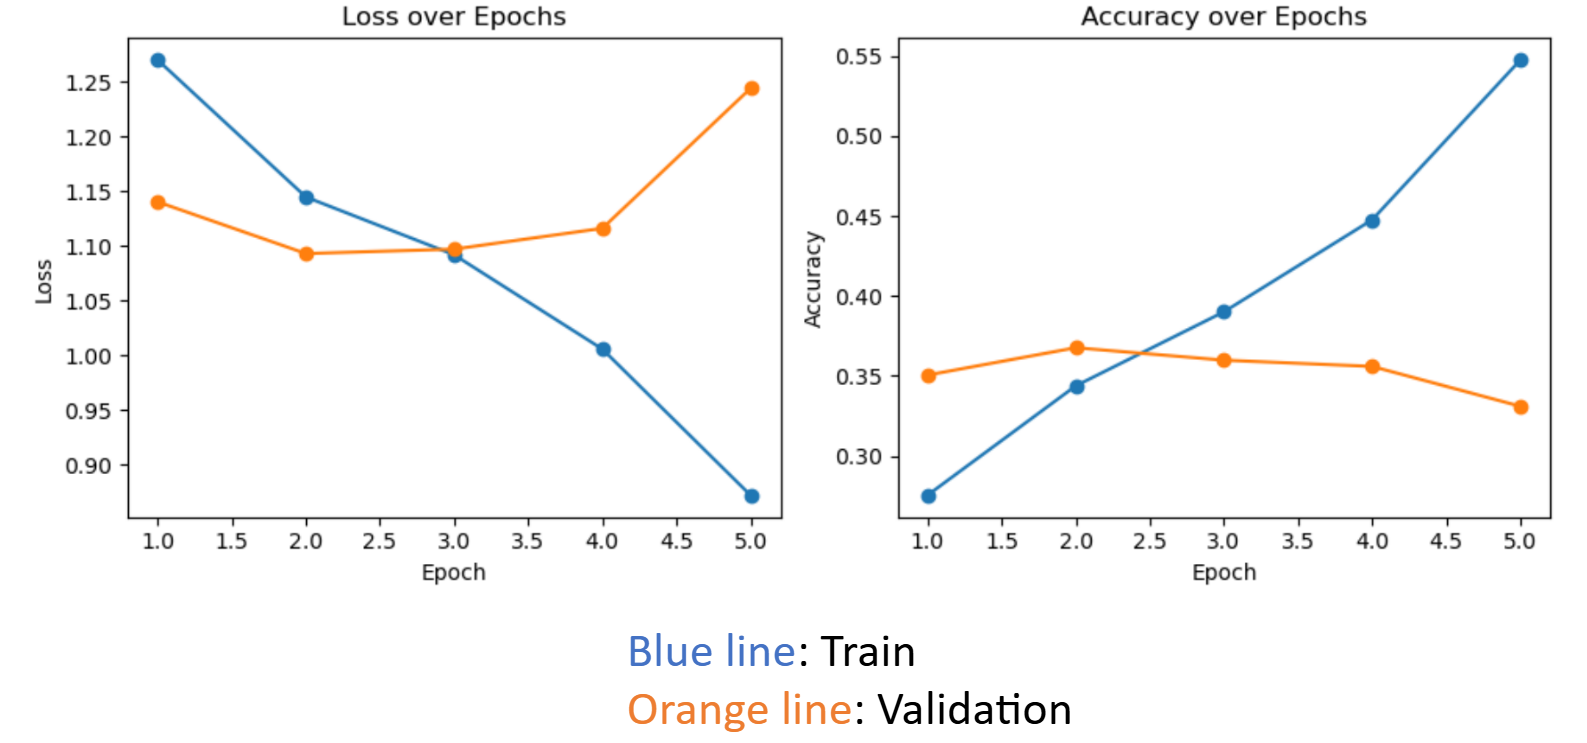

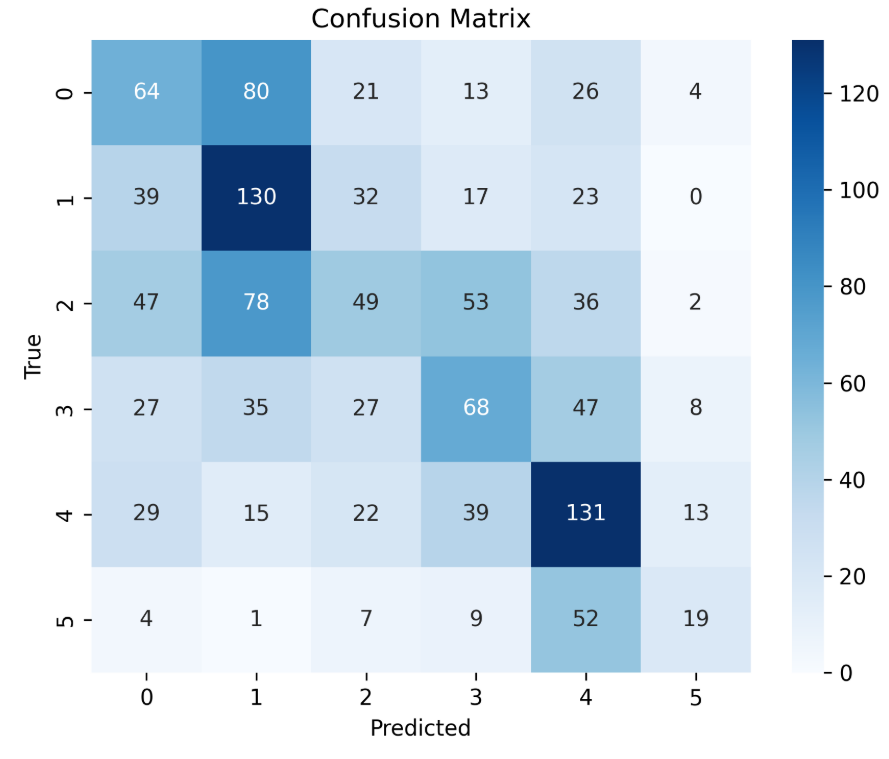

In [ ]:
## Final model
!python bert_network_with_VAT_RDrop.py

cuda:0
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f58241d9130>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f582412fd70>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f5823923c80>}
{'train': 10240, 'val': 1284, 'test': 1267}
starting
Epoch 1/100
----------
train total loss: 1.2699
train sentiment_acc: 0.2754

 Classification Report:
              precision    recall  f1-score   support

           0     0.2338    0.1014    0.1415      1676
           1     0.3389    0.3818    0.3591      1962
           2     0.2555    0.3543    0.2969      2114
           3     0.2060    0.1282    0.1580      1654
           4     0.2664    0.4100    0.3230      1995
           5     0.4469    0.1454    0.2194       839

    accuracy                         0.2754     10240
   macro avg     0.2913    0.2535    0.2497     10240
weighted avg     0.2778    0.2754    0.2597     10240


 Confusion Matrix:
[[170 443 557 123 370  13]
 [185 749 581  96 343  

## 5.3 Final Model Performance Comparison

1. Model performance comparison
   
| Measurements | Origin Model | Improvement 1 | Improvement 2 | Improvement 3 | Improvement 4 |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| Accuracy | 25.65% | 33.15% | 34.41% | 36.07% | 37.33% |
| Macro F1 | 0.2389 | 0.2587 | 0.3178 | 0.3315 | 0.3311 |

2. Analyze
   
Through a series of improvements, both Accuracy and Macro F1 scores have been significantly enhanced. Starting from an initial Accuracy of 25.65% and Macro F1 of 0.2389, the final model achieves 37.33% Accuracy and 0.3311 Macro F1. This demonstrates the effectiveness of the proposed modifications, leading to not only better overall performance but also a more balanced classification across different labels.


# 5.4 Why Data Augmentation failed

Despite the goal of improving model performance, the data augmentation pipeline resulted in doubling the dataset size without yielding the desired improvement. The additional augmented data, instead of enhancing the model's ability to generalise, introduced noise. As a result, the model became overly reliant on the original, unaugmented data, causing it to overfit on these samples, while struggling to adapt to the augmented data. 

This overreliance led to underfitting on the new varied data, reducing the effectiveness of the augmentation. To improve the results, it may be beneficial to explore alternative approaches such as embeddings-based augmentation, which focuses on semantically enriching the data rather than generating noisy variations. Furthermore, incorporating regularization techniques like dropout, early stopping, or L2 regularization could help mitigate overfitting, encouraging the model to generalize better and improve performance on both the original and augmented data.

## 5.5 Input feature significance analysis through feature analysis

In [ ]:
def evaluate_feature_ablation(model, criterion, test_data, test_size, feature_to_permute: int):
    index_to_feature = [
        "statement",
        "metadata",
        "credit",
    ]
    index_to_class = [
        "true",
        "mostly-true",
        "half-true",
        "barely-true",
        "false",
        "pants-fire",
    ]
    running_loss = 0.0
    sentiment_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, sentiment in test_data:
            inputs[feature_to_permute] = inputs[feature_to_permute].zero_()
            inputs1 = inputs[0]  # News statement input
            inputs2 = inputs[1]  # Meta data input
            inputs3 = inputs[2]  # Credit scores input

            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            inputs3 = inputs3.to(device)

            sentiment = sentiment.to(device)
            outputs = model(inputs1, inputs2, inputs3)
            outputs = F.softmax(outputs, dim=1)

            loss = criterion(outputs, sentiment.float())

            # statistics
            running_loss += loss.item() * inputs1.size(0)
            sentiment_corrects += torch.sum(torch.max(outputs, 1)
                                            [1] == torch.max(sentiment, 1)[1])
            pred_labels = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(sentiment, dim=1)
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

        epoch_loss = running_loss / test_size
        sentiment_acc = sentiment_corrects / test_size
    print(
        f"ablating features:{index_to_feature[feature_to_permute]}")
    print(f"\n🧪 Evaluation Results:")
    print(f"📉 Average Loss: {epoch_loss:.4f}")
    print(f"✅ Accuracy: {sentiment_acc * 100:.2f}%")

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds,
          target_names=index_to_class, digits=4, zero_division=0))

def test_feature_ablation():
    num_labels = 6
    model = BertForSequenceClassification(num_labels)
    model.to(device)
    criterion = AsymmetricLossSingleLabelOneHot(gamma_pos=1.0, gamma_neg=3.0)
    dataloaders_dict, dataset_sizes = load_dataset(
        train_path, test_path, val_path)

    model.load_state_dict(torch.load('bert_model_test_noFC1_triBERT.pth'))
    model.eval()
    features_to_permute = [0, 1, 2]

    for f in features_to_permute:
        evaluate_feature_ablation(
            model, criterion, dataloaders_dict['test'], dataset_sizes['test'], f)
        
test_feature_ablation()

As we can see the model experiences 18% reducton in prediction accuracy when the credit input feature was ablated in comparison with a ~3% and ~4% drop in accuracy for the statement and metadata. This difference suggests the credit input feature is not just a marginally more significant but in fact it may be responsible for the majority of the models accuracy.

## 6. Discussion

Our experiments demonstrate that the Dual-Branch Siamese BERT significantly outperforms traditional baselines and the single-branch BERT model.

**Strengths:**

- Integrating metadata and credit information clearly improved the model’s ability to differentiate between similar statements.

- Robust regularization techniques like VAT and R-Drop further enhanced the model’s generalization performance.

**Weaknesses:**

- The model's training time is considerably longer due to the complexity introduced by the dual-branch structure and adversarial training.

- Some labels, especially those underrepresented like "pants-fire," still suffered from lower recall, indicating room for improvement.

**Limitations and Future Work:**

- Explore using lighter transformer models like DistilBERT to reduce computational costs.

- Investigate different combinations of metadata (e.g., subject, speaker, state) to find the most influential features.

- Experiment with advanced loss functions like focal loss or contrastive learning to further handle class imbalance.

- Consider adding an independent parameter to modulate the impact of the credit.

## 7. Reference

[1]S. U. Hassan, J. Ahamed, and K. Ahmad, “Analytics of Machine Learning-based Algorithms for Text Classification,” Sustainable Operations and Computers, vol. 3, Apr. 2022, doi: https://doi.org/10.1016/j.susoc.2022.03.001.

[2]M. Das, Selvakumar Kamalanathan, and Alphonse, “A Comparative Study on TF-IDF feature Weighting Method and its Analysis using Unstructured Dataset,” arXiv (Cornell University), Aug. 2023, doi: https://doi.org/10.48550/arxiv.2308.04037.

[3]K. Borna and R. Ghanbari, “Hierarchical LSTM network for text classification,” SN Applied Sciences, vol. 1, no. 9, Aug. 2019, doi: https://doi.org/10.1007/s42452-019-1165-1.

[4]J. Devlin, M.-W. Chang, K. Lee, and K. Toutanova, “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding,” Proceedings of the 2019 Conference of the North, vol. 1, 2019, doi: https://doi.org/10.18653/v1/n19-1423.

[5] https://github.com/manideep2510/siamese-BERT-fake-news-detection-LIAR